# ETH Quantum Hackathon 2024
## NVIDIA challenge
### Caffeinated Qrackheads

### The Vehicle Routing Problem (VRP)



``The explanation (and maths) follows in the presentation``

#### Import necessary packages

In [1]:
import cudaq
import pandas as pd
from cudaq import spin
from networkx.algorithms.approximation import maxcut

### Import source files

In [2]:
from src.utilities import *
from src.QAOA import *
from src.QAOA_square import * 

### Running on an Apple M2 Pro Chip (up to 18 Qubits)

#### Defining pipeline for a QAOA Maxcut solver

In [3]:
def pipeline(nodes, seed, layer_count, shots_count, output=False):
    """
    This function runs the pipeline for the Max Cut problem using QAOA.

    Parameters
    ----------
    nodes : int
        The number of nodes in the graph.
    seed : int
        The seed for the random number generator.
    layer_count : int
        The number of layers in the QAOA ansatz.
    shots_count : int
        The number of shots for the quantum circuit.

    Returns
    -------
    None
    """
    G = nx.random_regular_graph(3, nodes, seed=seed)
    edges = list(G.edges())

    # Use the greedy approximation algorithm for Max Cut
    cut_value, partition_basic = maxcut.one_exchange(G, seed=seed)
    max_cut_gur, partition_gurobi = max_cut_gurobi(G)
    if output:
        print('#########################################################################################')
        print('CLASSICAL MAX CUT')
        print("Approximate Max Cut value:", cut_value)
        print("Partition basic:", partition_basic)
        print("Binary:", partition_to_bin(partition_basic))
        print("Start Gurobi Max Cut")
        print("Partition Gurobi:", partition_gurobi)
        visualize_max_cut(G, partition_gurobi, title="Gurobi Max Cut Partition")
        print('#########################################################################################')
        print('QUANTUM MAX CUT')
    
    start_time = time.time()

    edges_1 = [edges[i][0] for i in range(len(edges))]
    edges_2 = [edges[i][1] for i in range(len(edges))]
    hamiltonian = get_hamiltonian(edges)

    # Problem parameters
    qubit_count: int = hamiltonian.get_qubit_count()
    layer_count: int = layer_count
    parameter_count: int = 2 * layer_count
    shots_count: int = shots_count

    @cudaq.kernel
    def kernel_qaoa(edges_src: List[int], edges_tgt: List[int], qubit_count: int, layer_count: int, thetas: List[float]):
        """
        QAOA ansatz for Max-Cut
        
        Parameters
        ----------
        edges : List[Tuple[int, int]]
            The edges of the graph.
        qubit_count : int  
            The number of qubits.
        layer_count : int
            The number of layers in the QAOA ansatz.
        thetas : List[float]
            The angles for the QAOA ansatz.
        """
        qvector = cudaq.qvector(qubit_count)

        # Create superposition
        h(qvector)

        # Loop over the layers
        for layer in range(layer_count):
            for i, u in enumerate(edges_src):
                v = edges_tgt[i]
                x.ctrl(qvector[u], qvector[v])
                rz(2.0 * thetas[layer], qvector[v])
                x.ctrl(qvector[u], qvector[v])

            # Mixer unitary
            for qubit in range(qubit_count):
                rx(2.0 * thetas[layer + layer_count], qvector[qubit])

    # Make it repeatable with fixing random seeds
    cudaq.set_random_seed(42)
    np.random.seed(42)

    # Specify the optimizer and its initial parameters for the angles in the layers
    optimizer = cudaq.optimizers.COBYLA()
    optimizer.initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0, parameter_count)

    if output:
        print("Print circuit of single QAOA layer")
        print(cudaq.draw(kernel_qaoa, edges_1, edges_2, qubit_count, 1, [1,1]))
        print("Initial QAOA parameters = ", optimizer.initial_parameters)

    def objective(parameters):
        """
        Compute the expected value of the hamiltonian with respect to the kernel.

        Parameters
        ----------
        parameters : List[float]
            The parameters to optimize. Contains the angles for the qaoa ansatz.

        Returns
        -------
        result : float
            The expectation value of the hamiltonian: <state(params) | H | state(params)>
        """
        return cudaq.observe(kernel_qaoa, hamiltonian, edges_1, edges_2, qubit_count, layer_count, parameters).expectation()

    optimal_expectation, optimal_parameters = optimizer.optimize(
        dimensions=parameter_count, function=objective)
    
    execution_time = time.time() - start_time

    # Sample the circuit using the optimized parameters
    counts = cudaq.sample(kernel_qaoa, edges_1, edges_2, qubit_count, layer_count, optimal_parameters, shots_count=1000000)
    results = sorted(counts.items(), key=lambda x: x[1], reverse=True)

    # Print the optimized value and its parameters
    if output:
        print("Optimal expectation value = ", optimal_expectation)
        print("Optimal parameters = ", optimal_parameters)
        for key, value in results[:10]:
            print(f"{key}: {value}")

    partition_qaoa = bin_to_partition(results[0][0])

    if output:
        print("Partition QAOA:", partition_qaoa)
        visualize_max_cut(G, partition_qaoa, title="QAOA Max Cut Partition")
        print("Cost function QAOA:", cost_function_qaoa(results, edges))

    result_dict = {
        'nodes': nodes,
        'seed': seed,
        'runtime': execution_time,
        'partition_gurobi': partition_gurobi,
        'partition_qaoa': partition_qaoa,
        'cost_gurobi': max_cut_gur,
        'cost_qaoa': cost_function_qaoa(results, edges)
    }

    return result_dict


### Running pipeline

In [4]:
times_2_layers = []
seed = 42
start_time = time.time()
for nodes in np.arange(4, 20, 2):
    times_2_layers.append(pipeline(nodes=nodes, seed=int(seed), layer_count=2, shots_count=1000))
print(f"Elapsed time: {time.time() - start_time} seconds")

results_df = pd.DataFrame(times_2_layers)
display(results_df)

Restricted license - for non-production use only - expires 2025-11-24


Max-Cut Value: 4
Max-Cut Value: 7
Max-Cut Value: 10
Max-Cut Value: 13
Max-Cut Value: 16
Max-Cut Value: 17
Max-Cut Value: 22
Max-Cut Value: 24
Elapsed time: 14.48679494857788 seconds


,nodes,seed,runtime,partition_gurobi,partition_qaoa,cost_gurobi,cost_qaoa
0,4,42,1.140960,"[{1, 3}, {0, 2}]","({0, 2}, {1, 3})",4,4
1,6,42,1.062413,"[{0, 4, 5}, {1, 2, 3}]","({1, 2, 3}, {0, 4, 5})",7,7
2,8,42,0.812279,"[{0, 3, 4, 7}, {1, 2, 5, 6}]","({1, 3, 5, 6}, {0, 2, 4, 7})",10,10
3,10,42,0.939384,"[{0, 1, 2, 4, 7}, {3, 5, 6, 8, 9}]","({3, 5, 6, 8, 9}, {0, 1, 2, 4, 7})",13,13
4,12,42,3.364757,"[{1, 3, 4, 8, 9, 10}, {0, 2, 5, 6, 7, 11}]","({0, 2, 5, 6, 7, 11}, {1, 3, 4, 8, 9, 10})",16,16
5,14,42,1.142626,"[{0, 1, 5, 8, 9, 12, 13}, {2, 3, 4, 6, 7, 10, ...","({0, 3, 5, 8, 9, 12, 13}, {1, 2, 4, 6, 7, 10, ...",17,17
6,16,42,0.750525,"[{3, 5, 8, 9, 10, 11, 12, 14}, {0, 1, 2, 4, 6,...","({0, 1, 2, 4, 6, 7, 13, 15}, {3, 5, 8, 9, 10, ...",22,22
7,18,42,1.187557,"[{2, 5, 6, 8, 9, 10, 11, 13}, {0, 1, 3, 4, 7, ...","({0, 1, 3, 4, 7, 12, 14, 15, 16, 17}, {2, 5, 6...",24,24


### Using GPU access to the NVIDIA A100


In [5]:
# Having access to an NVIDIA GPU in the cloud, we simply run
cudaq.set_target("nvidia")
# TODO: float
# and then run the pipeline again
times_2_layers = []
seed = 42
start_time = time.time()
for nodes in np.arange(4, 20, 2):
    times_2_layers.append(pipeline(nodes=nodes, seed=int(seed), layer_count=2, shots_count=1000))
print(f"Elapsed time: {time.time() - start_time} seconds")

results_df = pd.DataFrame(times_2_layers)
display(results_df)


Max-Cut Value: 4
Max-Cut Value: 7
Max-Cut Value: 10
Max-Cut Value: 13
Max-Cut Value: 16
Max-Cut Value: 17
Max-Cut Value: 22
Max-Cut Value: 24
Elapsed time: 14.704543590545654 seconds


,nodes,seed,runtime,partition_gurobi,partition_qaoa,cost_gurobi,cost_qaoa
0,4,42,0.875983,"[{1, 3}, {0, 2}]","({0, 2}, {1, 3})",4,4
1,6,42,0.923077,"[{0, 4, 5}, {1, 2, 3}]","({1, 2, 3}, {0, 4, 5})",7,7
2,8,42,0.806689,"[{0, 3, 4, 7}, {1, 2, 5, 6}]","({1, 3, 5, 6}, {0, 2, 4, 7})",10,10
3,10,42,0.996652,"[{0, 1, 2, 4, 7}, {3, 5, 6, 8, 9}]","({3, 5, 6, 8, 9}, {0, 1, 2, 4, 7})",13,13
4,12,42,3.617401,"[{1, 3, 4, 8, 9, 10}, {0, 2, 5, 6, 7, 11}]","({0, 2, 5, 6, 7, 11}, {1, 3, 4, 8, 9, 10})",16,16
5,14,42,1.173529,"[{0, 1, 5, 8, 9, 12, 13}, {2, 3, 4, 6, 7, 10, ...","({0, 3, 5, 8, 9, 12, 13}, {1, 2, 4, 6, 7, 10, ...",17,17
6,16,42,0.809727,"[{3, 5, 8, 9, 10, 11, 12, 14}, {0, 1, 2, 4, 6,...","({0, 1, 2, 4, 6, 7, 13, 15}, {3, 5, 8, 9, 10, ...",22,22
7,18,42,1.344685,"[{2, 5, 6, 8, 9, 10, 11, 13}, {0, 1, 3, 4, 7, ...","({0, 1, 3, 4, 7, 12, 14, 15, 16, 17}, {2, 5, 6...",24,24


### Divide and Conquer


### Define pipeline

In [8]:
def pipeline_dac(n_nodes, partition_size):
    """
    This function runs the pipeline for the Max Cut problem using QAOA with divide and conquer.
    
    Parameters
    ----------
    n_nodes : int
        The number of nodes in the graph.
    partition_size : int
        The size of the subgraph to partition.
    
    Returns
    -------
    result_dict : dict
        A dictionary containing the results of the pipeline.
    """

    start = time.time()

    graph, edges = generate_regular_3_graph(n_nodes, seed=42)
    G = Graph(v=list(range(n_nodes)), edges=edges)

    # Classical solution
    gurobi_sol = max_cut_gurobi(graph)
    if gurobi_sol is not None:
        print(f'Gurobi partition: {gurobi_sol[1]}')

    
    _, sols = qaoa_square(G, depth=2, sub_size=partition_size, partition_method='modularity')
    
    # reconstruct the partition from the divide and conquer solution
    dac_partition = contract_solution(sols, sort=True)[0]['sol']
    dac_partition_v = sols[0]['v']
    dac_cost = get_cost(dac_partition, edges)
    
    # print(f'D&C max-cut value: {dac_cost}')
    # print(f'D&C partition: {dac_partition_v}')

    result_dict = {
        'nodes': nodes,
        'seed': seed,
        'runtime': time.time() - start,
        'partition_gurobi': gurobi_sol[1],
        'partition_qaoa': dac_partition_v,
        'cost_gurobi': gurobi_sol[0],
        'cost_qaoa': dac_cost
    }
    return result_dict
        

### Run divide and conquer

In [9]:
times_2_layers = []
seed = 42
partition_size = 6 # Size of the subproblems
start_time = time.time()
for nodes in np.arange(4, 20, 2): # Small because of time it needs to run on CPU
    times_2_layers.append(pipeline_dac(nodes, partition_size=min(partition_size, nodes//2)))
print(f"Elapsed time: {time.time() - start_time} seconds")

results_df = pd.DataFrame(times_2_layers)
display(results_df)

Max-Cut Value: 4
Gurobi partition: [{1, 3}, {0, 2}]
Max-Cut Value: 7
Gurobi partition: [{0, 4, 5}, {1, 2, 3}]
Max-Cut Value: 10
Gurobi partition: [{0, 3, 4, 7}, {1, 2, 5, 6}]
Max-Cut Value: 13
Gurobi partition: [{0, 1, 2, 4, 7}, {3, 5, 6, 8, 9}]
Max-Cut Value: 16
Gurobi partition: [{1, 3, 4, 8, 9, 10}, {0, 2, 5, 6, 7, 11}]
Max-Cut Value: 17
Gurobi partition: [{0, 1, 5, 8, 9, 12, 13}, {2, 3, 4, 6, 7, 10, 11}]
Max-Cut Value: 22
Gurobi partition: [{3, 5, 8, 9, 10, 11, 12, 14}, {0, 1, 2, 4, 6, 7, 13, 15}]
Max-Cut Value: 24
Gurobi partition: [{2, 5, 6, 8, 9, 10, 11, 13}, {0, 1, 3, 4, 7, 12, 14, 15, 16, 17}]
Elapsed time: 23.83167839050293 seconds


,nodes,seed,runtime,partition_gurobi,partition_qaoa,cost_gurobi,cost_qaoa
0,4,42,1.811843,"[{1, 3}, {0, 2}]","[[0, 1], [2, 3]]",4,4
1,6,42,2.677665,"[{0, 4, 5}, {1, 2, 3}]","[[0, 1, 2], [3, 4, 5]]",7,7
2,8,42,2.777454,"[{0, 3, 4, 7}, {1, 2, 5, 6}]","[[0, 1, 2, 3], [4, 5, 6, 7]]",10,8
3,10,42,2.538918,"[{0, 1, 2, 4, 7}, {3, 5, 6, 8, 9}]","[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]]",13,12
4,12,42,1.998244,"[{1, 3, 4, 8, 9, 10}, {0, 2, 5, 6, 7, 11}]","[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11]]",16,11
5,14,42,3.965363,"[{0, 1, 5, 8, 9, 12, 13}, {2, 3, 4, 6, 7, 10, ...","[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11], [12...",17,16
6,16,42,3.224355,"[{3, 5, 8, 9, 10, 11, 12, 14}, {0, 1, 2, 4, 6,...","[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11], [12...",22,16
7,18,42,4.837362,"[{2, 5, 6, 8, 9, 10, 11, 13}, {0, 1, 3, 4, 7, ...","[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11], [12...",24,19


### Final Plots

In [1]:
import pandas as pd

data_cpu_4_18 = pd.read_csv('./results/CPU_results.csv')
data_GPU_4_36 = pd.read_csv('./results/results_qaoa_4_36_gpu.csv')

gurobi_cost_cpu = data_cpu_4_18['cost_gurobi']
qaoa_cost_cpu = data_cpu_4_18['cost_qaoa']
qaoa_runtime_cpu = data_cpu_4_18['runtime']
nb_qubits_cpu = data_cpu_4_18['nodes']


gurobi_cost_gpu = data_GPU_4_36['cost_gurobi']
qaoa_cost_gpu = data_GPU_4_36['cost_qaoa']
qaoa_runtime_gpu = data_GPU_4_36['runtime']
nb_qubits_gpu = data_GPU_4_36['nodes']

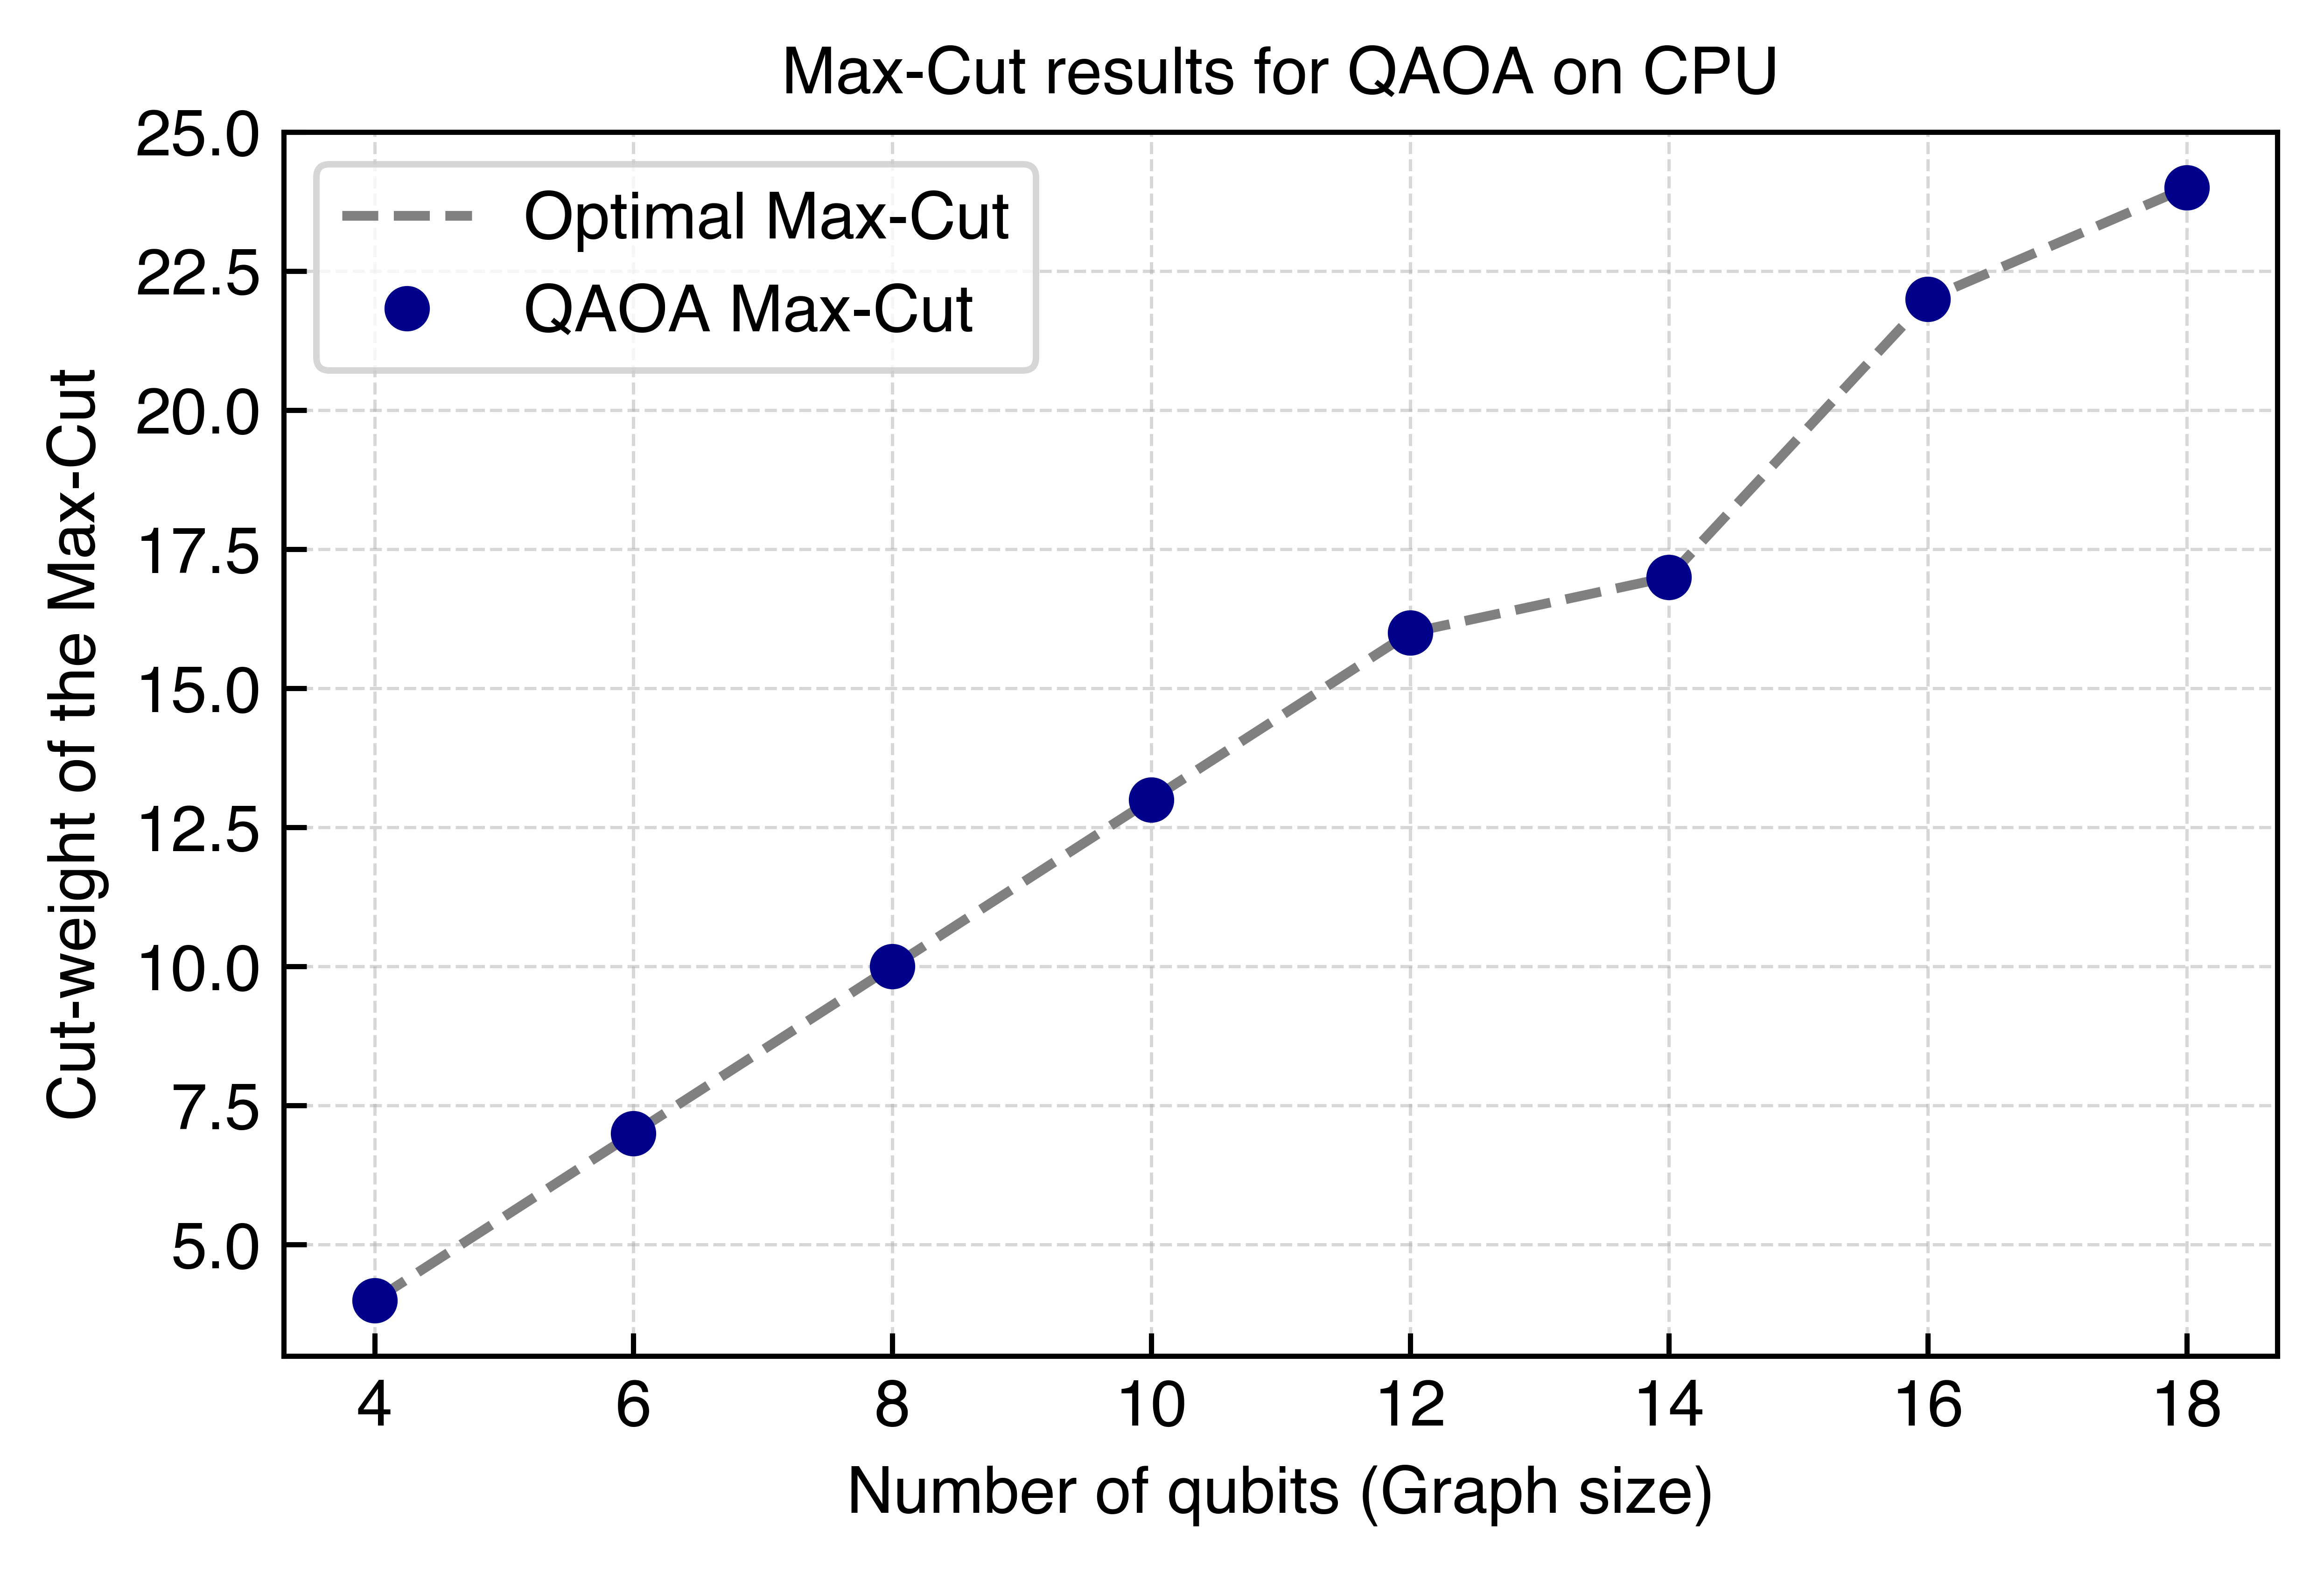

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from src.general import apply_formatting


apply_formatting()
plt.plot(nb_qubits_cpu, gurobi_cost_cpu, label='Optimal Max-Cut', color='grey', linestyle='--')
plt.plot(nb_qubits_cpu, qaoa_cost_cpu, label='QAOA Max-Cut', color='darkblue', marker='o', linewidth = 0)


plt.xlabel('Number of qubits (Graph size)')
plt.ylabel(r'Cut-weight of the Max-Cut')

plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title('Max-Cut results for QAOA on CPU')
plt.show()

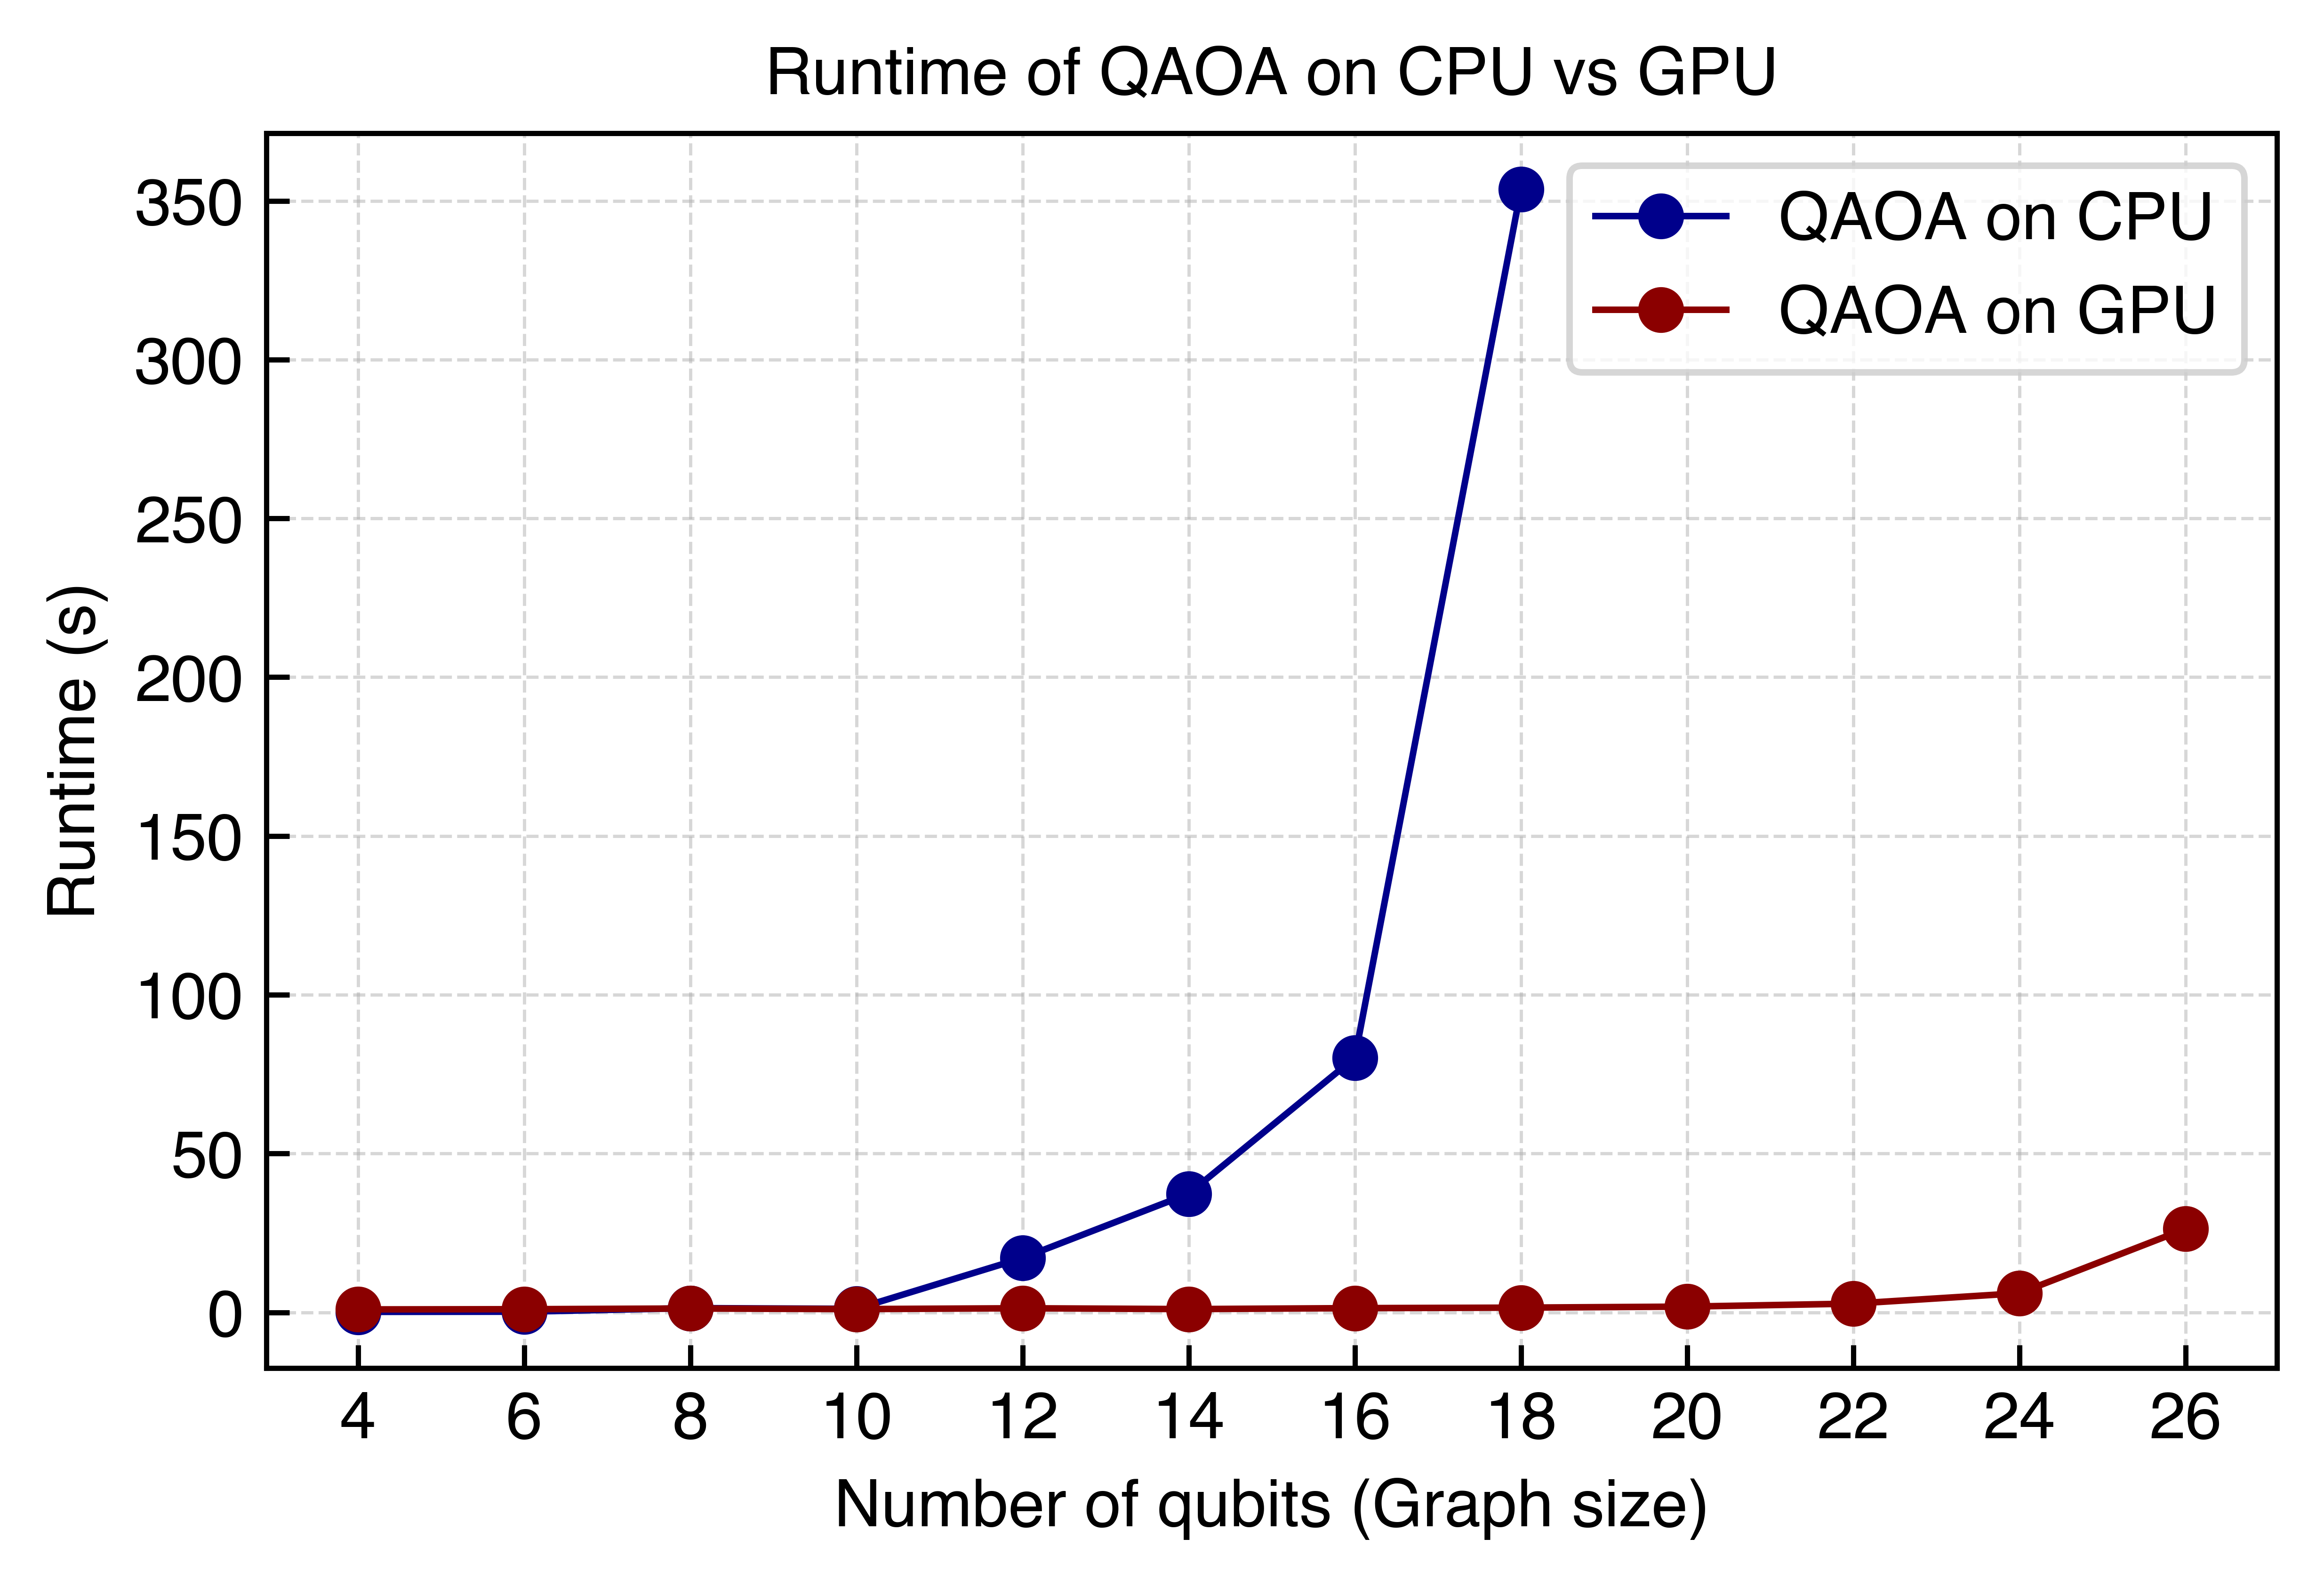

In [5]:
apply_formatting()
plt.plot(nb_qubits_cpu[:-1], qaoa_runtime_cpu[:-1], label='QAOA on CPU', color='darkblue', marker='o', linewidth = 1)
plt.plot(nb_qubits_gpu, qaoa_runtime_gpu, label='QAOA on GPU', color='darkred', marker='o', linewidth = 1)


plt.xlabel('Number of qubits (Graph size)')
plt.ylabel('Runtime (s)')

plt.xticks(nb_qubits_gpu)

plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title('Runtime of QAOA on CPU vs GPU')
plt.show()

# RUNTIME 18 qubits
# CPU: 353.6s
# GPU: 1.5s (236x faster)


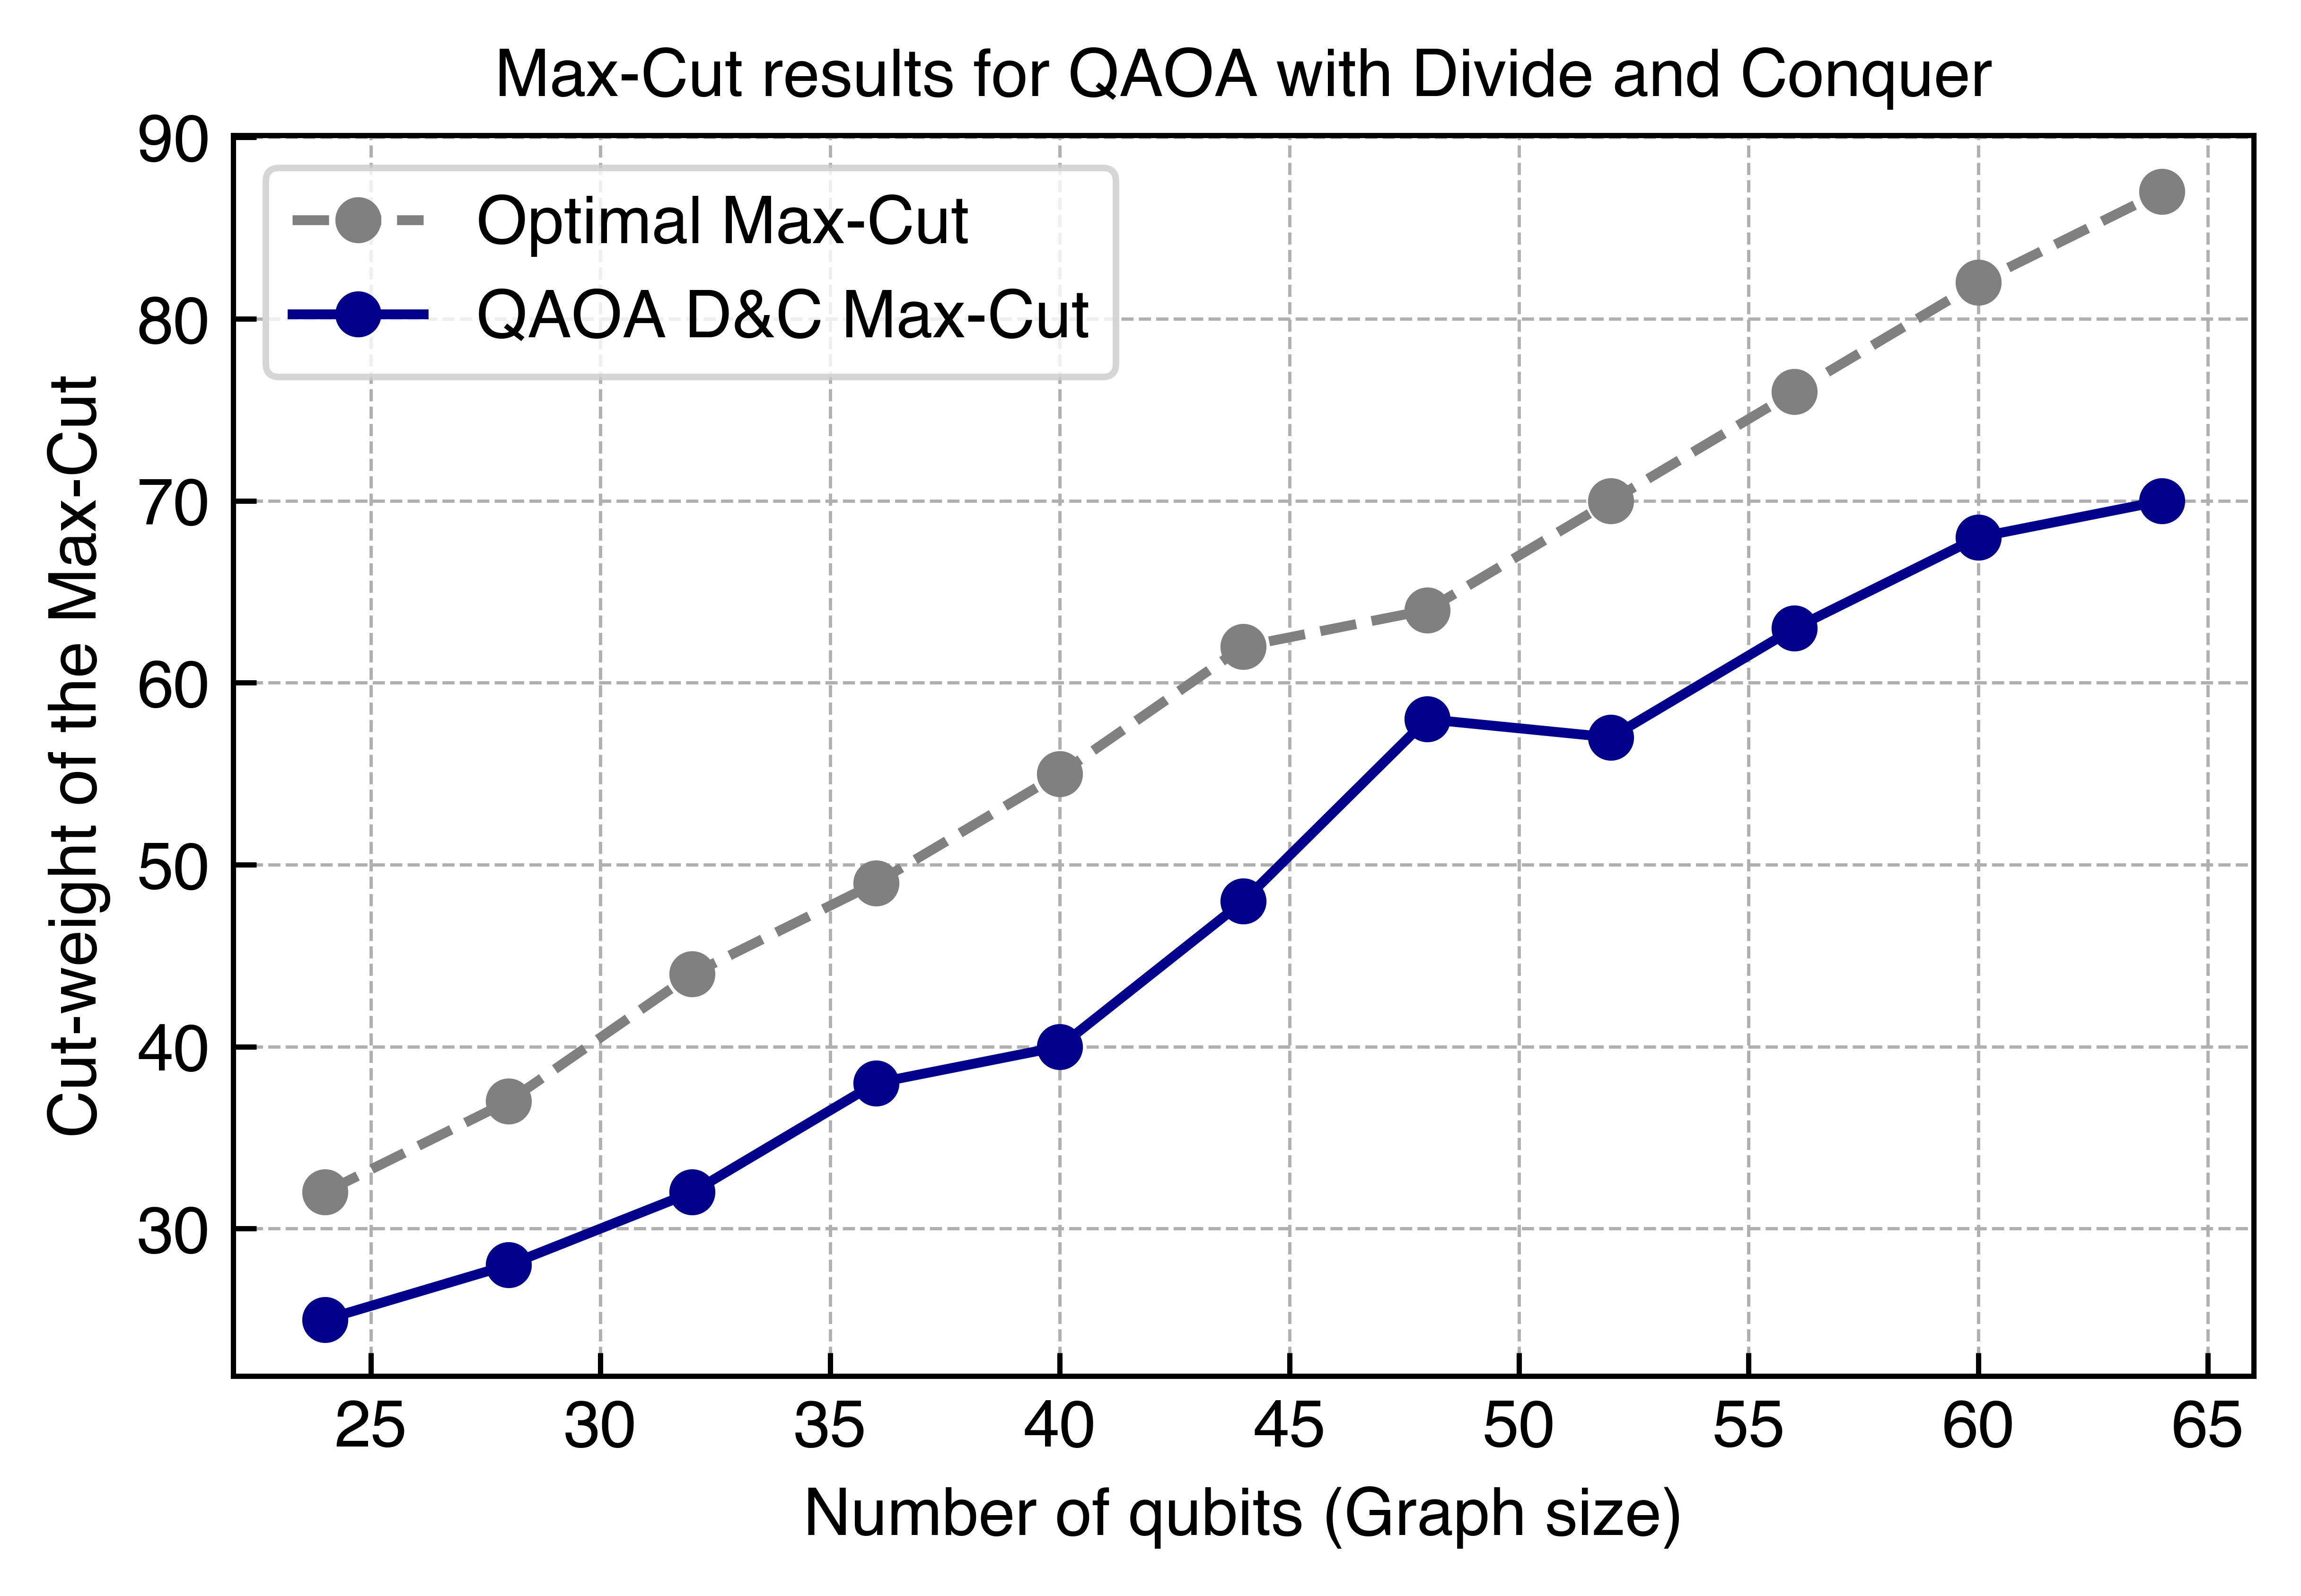

In [11]:
data = pd.read_csv('./results/results_dac_2.csv')
ratios = data['cost_dac'] / data['cost_gurobi']
nb_qubits = data['nodes']
runtimes = data['runtime']

gurobi_cut = data['cost_gurobi']
dac_cut = data['cost_dac']

plt.plot(nb_qubits, gurobi_cut, label='Optimal Max-Cut', color='grey', linestyle='--', marker='o')
plt.plot(nb_qubits, dac_cut, label='QAOA D&C Max-Cut', color='darkblue', marker='o')
# plt.plot(nb_qubits, dac_cut, label='DAC', marker='o')
plt.xlabel('Number of qubits (Graph size)')
plt.ylabel(r'Cut-weight of the Max-Cut')

plt.title('Max-Cut results for QAOA with Divide and Conquer')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

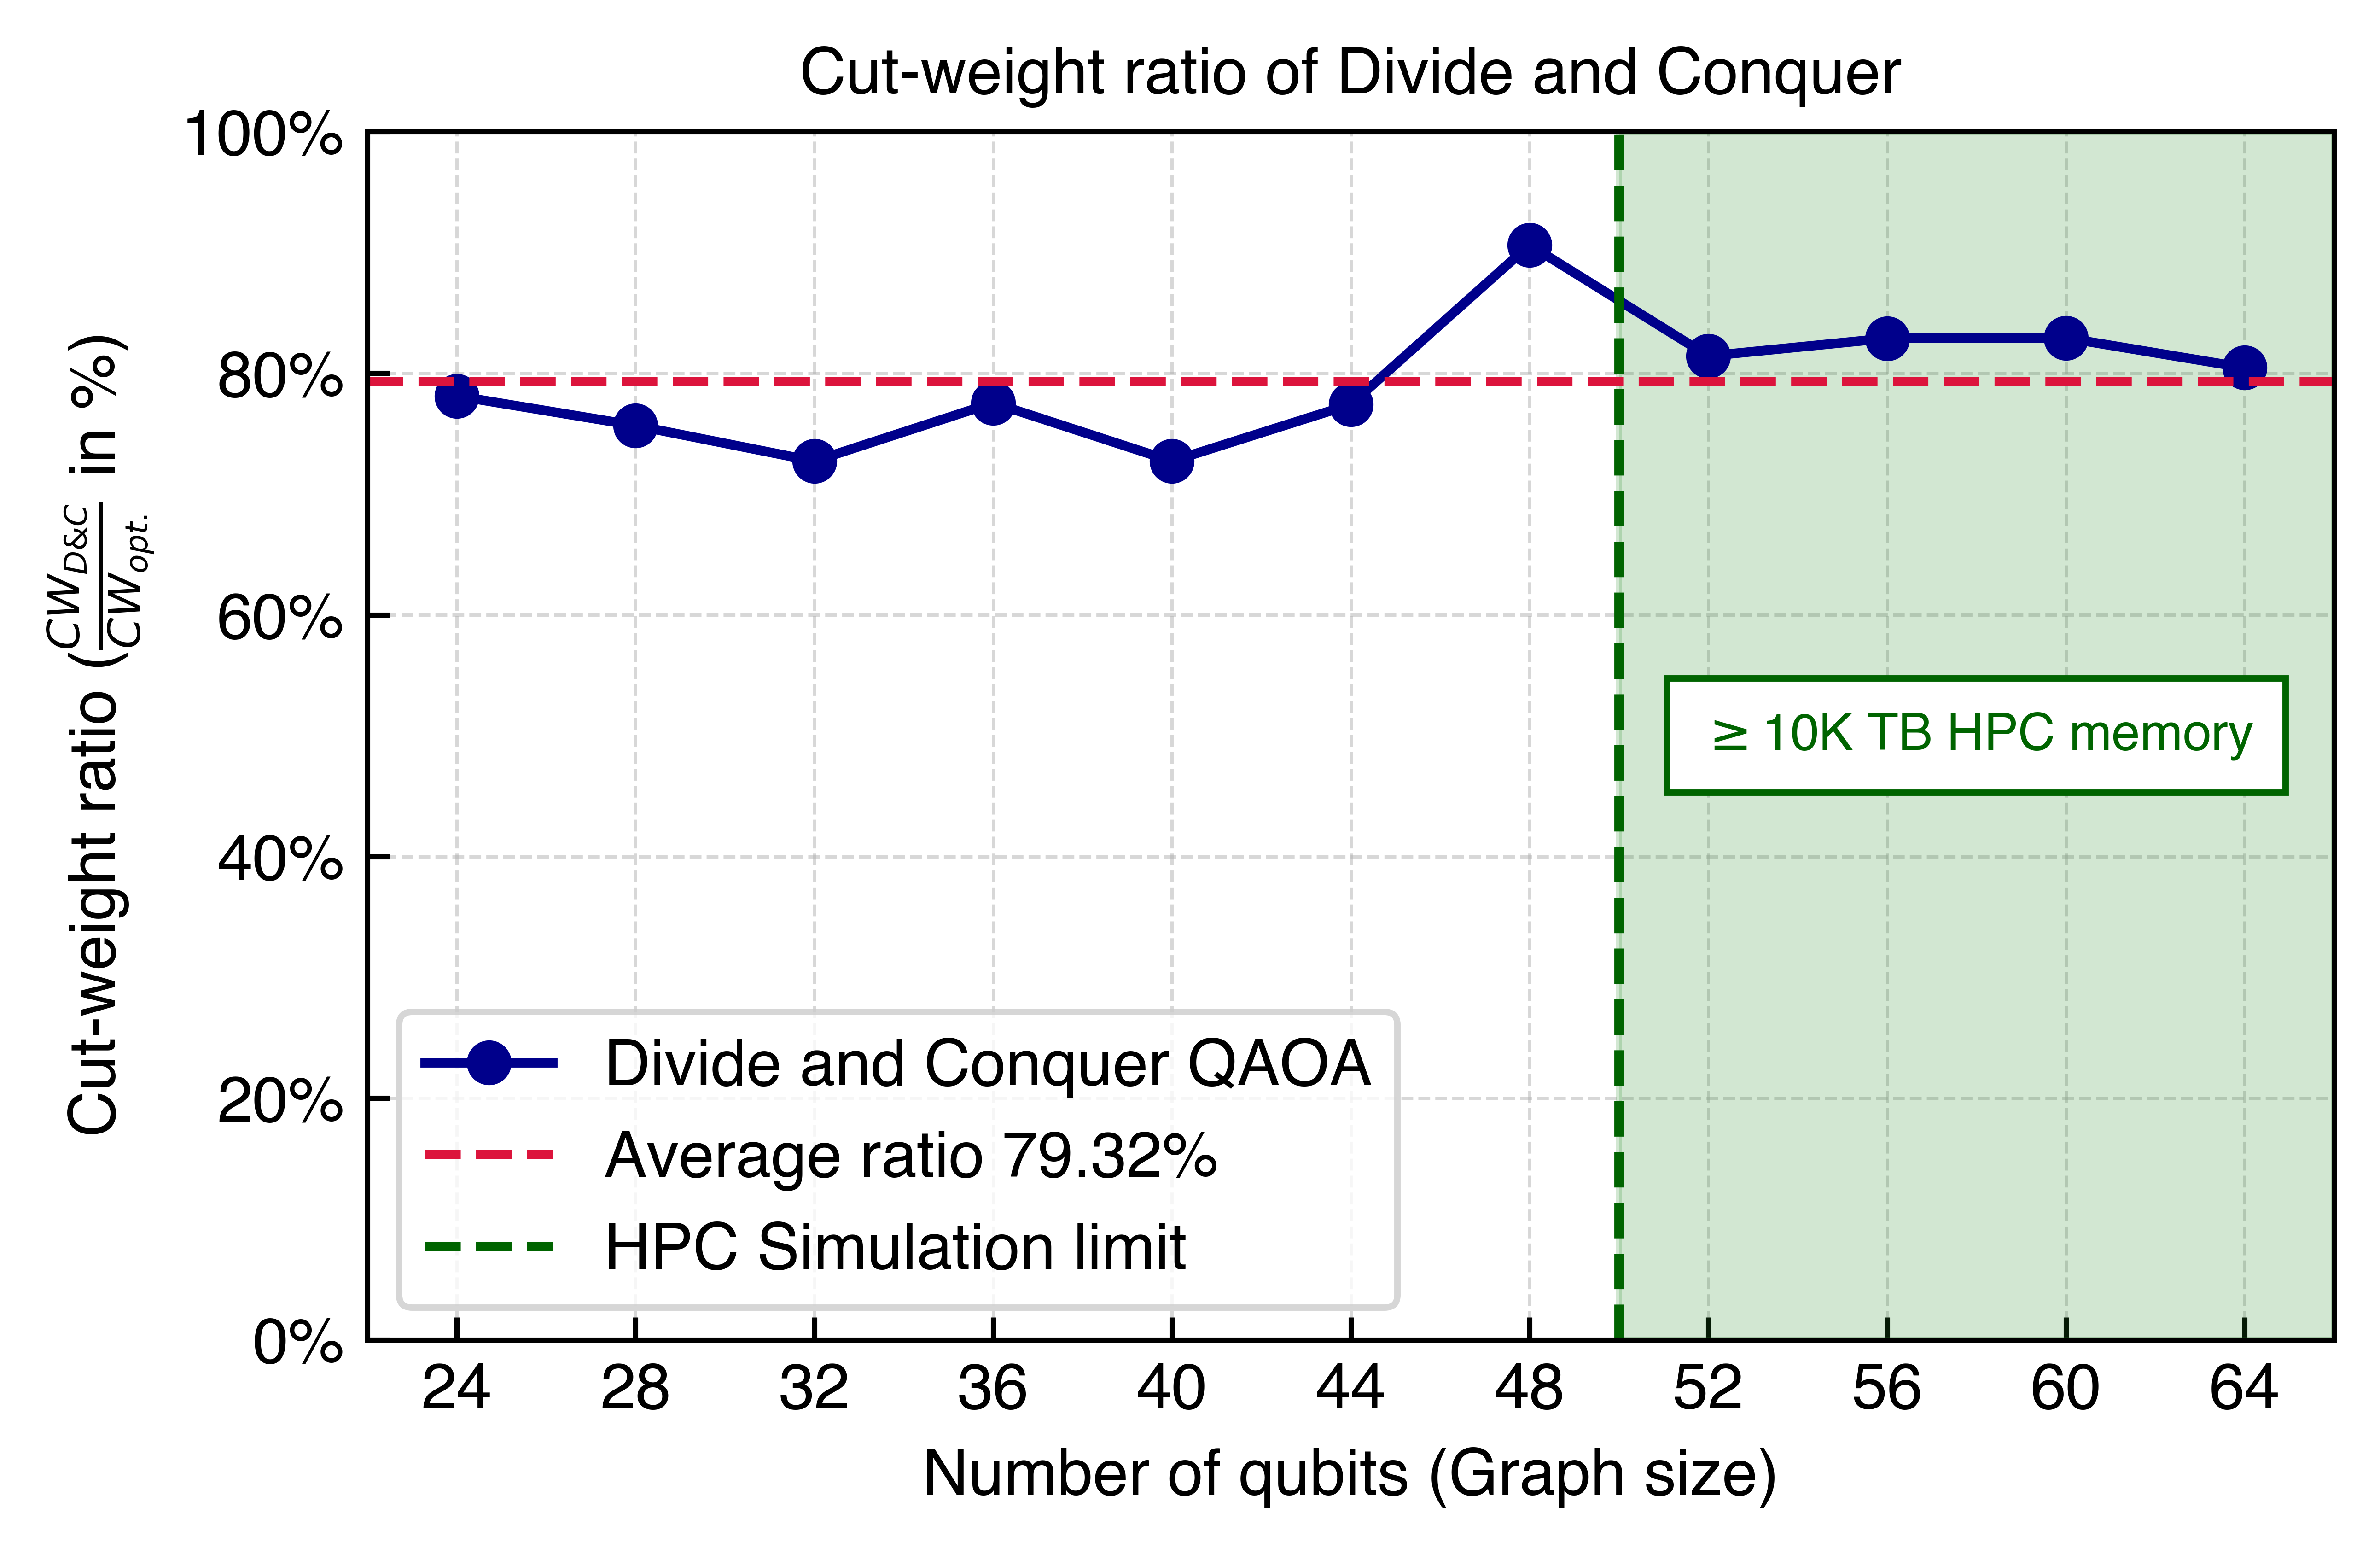

In [12]:
from matplotlib.ticker import FuncFormatter


def to_percent(y, position):
    # Use the '%' symbol with the format. Avoid multiplying by 100 here, as it's done in the plot.
    return f"{y:.0f}%"

apply_formatting()
plt.plot(nb_qubits, ratios*100, marker='o', linestyle='-', label='Divide and Conquer QAOA', color='darkblue')    

# Add a horizontal line at the average ratio
yvalue = np.mean(ratios)*100
plt.axhline(y=yvalue, color='crimson', linestyle='--', label=f'Average ratio {yvalue:.2f}%')

# Add a vertical line at x=50 qubits
xvalue = 50
plt.axvline(x=xvalue, color='darkgreen', linestyle='--', label='HPC Simulation limit')
plt.text(58, 50, r'$\geq$10K TB HPC memory', verticalalignment='center', horizontalalignment='center',
         color='darkgreen',  bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5, 'edgecolor': 'darkgreen'}, fontsize=8)

# Shade the area to the right of x=50
xlim_bef = plt.xlim()
plt.axvspan(xvalue, xlim_bef[1], color='forestgreen', alpha=0.2)


plt.xlabel('Number of qubits (Graph size)')
plt.ylabel(r'Cut-weight ratio ($\frac{CW_{D&C}}{CW_{opt.}}$ in %)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.xticks(nb_qubits)
plt.ylim(0, 100)
plt.xlim(xlim_bef)
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title('Cut-weight ratio of Divide and Conquer')
plt.show()
